In [4]:
# Для н.с.
from tensorflow.keras.models import Model # Импортируем модели keras: Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization, Flatten, Dense, Dropout, Conv2DTranspose, Concatenate, Reshape
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam # оптимизатор Adam
from tensorflow.keras import callbacks
from tensorflow.keras import utils # Для получения OHE-представления
from tensorflow.keras.preprocessing import image # Для работы с изображениями
from sklearn.model_selection import train_test_split


import matplotlib.pyplot as plt # для построения графиков
import numpy as np # 
import time
import random
import math
from PIL import Image # Для работы с изображениями
import datetime

In [5]:
import os # Импортируем библиотеку os для работы с фаловой системой

# Монтируем наш Google-диск
from google.colab import files # Импортируем Модуль files для работы с файлами
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# Функция умной обрезки
def smart_trimming(img):
  img_w, img_h = img.size   # Берём размер картинки
  target_size = [130, 110]  # Размер, который мы должны получить в результате

  # Проверка на формат
  if img_w > img_h:
    new_h = target_size[1]                # Делаем высоту основной осью
    new_w = round(new_h / img_h * img_w)  # Считаем ширину
  else:
    new_w = target_size[0]                # Делаем ширину основной осью
    new_h = round(new_w / img_w * img_h)  # Считаем высоту

  # Применяем наши измениния касательно размеров
  img = img.resize((new_w, new_h), Image.ANTIALIAS)

  # Находим центр картинки
  center = [new_w//2, new_h//2]
  # Находим левую верхнюю и правую нижнюю точки для прямоугольной обрезки
  top_left = [center[0] - target_size[0]//2, center[1] - target_size[1]//2]
  bottom_right = [center[0] + target_size[0]//2, center[1] + target_size[1]//2]

  # Обрезаем изображение
  img = img.crop((top_left[0], top_left[1], bottom_right[0], bottom_right[1]))

  return img

In [11]:
dataset_zip = '/content/drive/MyDrive/Colab\ Notebooks/Machine_learning/Datasets/flowers.zip'
dataset = '/content/flowers_dataset' #Место, куда будем распаковывать архив.


labels = {} # Создадим словарь
# Будем хранить вероятности, соответствующие верным ответам для каждого ключа
labels['daisy']     = [1,0,0,0,0]
labels['dandelion'] = [0,1,0,0,0]
labels['rose']      = [0,0,1,0,0]
labels['sunflower'] = [0,0,0,1,0]
labels['tulip'] =     [0,0,0,0,1]

In [9]:
# Удалить директорию, куда разархивируем датасет
!rm -rf {dataset}

In [12]:
# Распаковываем наш архив в пространство Colab
!unzip -q {dataset_zip} -d {dataset}

In [13]:
image_list = [] # Список путей ко всем изображениям цветов

for label in labels.keys():
  dir = dataset + "/flowers/" + label
  flist = os.listdir(dir)
  for f in flist:
    fpath = dataset+"/flowers/" + label + "/" + f 
    image_list.append(fpath)

In [14]:
# Перемешиваем список, чтобы учить нейросеть на каждой эпохе с разными весами учить на разных цветах.
random.shuffle(image_list)

x_train = []
y_train = []

In [15]:
for fpath in image_list: # Идём по всем изображениям

  # Приводим иозображения к единому формату.
  img = Image.open(fpath)
  img = smart_trimming(img)

  img = np.array(img) #Переводим изображения в np массивы
  x_train.append(img) #Добавляем изображение в тренировочную выборку

  # Формируем верные ответы на изображения используя слово, что состоит в их названиях
  label = fpath.split('/')[4]
  y_train.append(labels[label])

In [16]:
x_train = np.array(x_train)
y_train = np.array(y_train)

In [22]:
# Вывод размерности обучающей выборки
print("Размерность x_train", x_train.shape) # Имеет странную размерность. Может быть связано с форматом .jpg
print()
print("Размерность y_train", y_train.shape)

Размерность x_train (4317, 110, 130, 3)

Размерность y_train (4317, 5)


In [23]:
# Разобъем обучающую выборку на выборки

# Проверочная выборка
x_val = x_train[4000:]
y_val = y_train[4000:]

# Обучающая выборка
x_train = x_train[0:4000]
y_train = y_train[0:4000]

print("Обучающая выборка:")
print(x_train.shape)
print(y_train.shape)
print()

print("Проверочная выборка:")
print(x_val.shape)
print(y_val.shape)
print()

Обучающая выборка:
(4000, 110, 130, 3)
(4000, 5)

Проверочная выборка:
(317, 110, 130, 3)
(317, 5)



In [24]:
# задаём batch_size
batch_size = 32 # Часто меняем веса, т.к. датасет маленький.

# Создаем последовательную модель
model = Sequential()

# Слой пакетной нормализации
model.add(BatchNormalization(input_shape=(110, 130, 3), name="bn1"))
# Первый сверточный слой
model.add(Conv2D(32, (3, 3), padding='same', activation='relu', name="Conv2D-layer1"))
# Первый слой уменьшения изображения в 2 раза
model.add(MaxPooling2D(pool_size=(2, 2), name="mp2D-layer1"))
model.add(Dropout(0.2))

model.add(BatchNormalization())
# Второй сверточный слой
model.add(Conv2D(64, (3, 3), padding='same', activation='relu', name = "Conv2D-layer3"))

# Третий сверточный слой
model.add(Conv2D(64, (3, 3), padding='same', activation='relu', name = "Conv2D-layer4"))

# Второй слой уменьшения изображения в 2 раза
model.add(MaxPooling2D(pool_size=(2, 2), name="mp2D-layer2"))

model.add(Dropout(0.2))

model.add(BatchNormalization())
# Пятый сверточный слой
model.add(Conv2D(128, (3, 3), padding='same', activation='relu', name = "Conv2D-layer5"))
# Шестой сверточный слой
model.add(Conv2D(128, (3, 3), padding='same', activation='relu', name = "Conv2D-layer6"))
# Третий слой уменьшения изображения в 2 раза
model.add(MaxPooling2D(pool_size=(2, 2), name="mp2D-layer3"))
model.add(Dropout(0.2))

model.add(BatchNormalization())
# Слой преобразования данных из 2D представления в плоское
model.add(Flatten(name="flatten"))
# Выходной полносвязный классифицирующий слой
model.add(Dense(5, activation='softmax', name = "labels"))

# Компилируем сеть
model.compile(loss="categorical_crossentropy", optimizer=Adam(), metrics=["accuracy"])

In [25]:
# Сохранение весов с помощью функции колбэка.
# На каждой эпохе с указанием даты обучения и ошибки:

weights_path = '/content/weights/fl-@@dt@@_{epoch:03d}-{val_loss:.6f}.hdf5'

now = datetime.datetime.now() # Получение текущей даты и времени
now = now.strftime("%4Y-%2m-%2d_%2H-%2M") # Приведение к формату
weights_path = weights_path.replace("@@dt@@", now) #Вставка в путь, для сохранения

# Функциия колбэка
model_checkpoint_callback = callbacks.ModelCheckpoint(
   filepath=weights_path,
   save_weights_only=True,
   monitor='val_loss',
   mode='min',
   save_best_only=False)

Epoch 1/10
125/125 [==============================] - 3s 19ms/step - loss: 2.1932 - accuracy: 0.4415 - val_loss: 2.8746 - val_accuracy: 0.3470
Epoch 2/10
125/125 [==============================] - 2s 18ms/step - loss: 1.6406 - accuracy: 0.5608 - val_loss: 1.3933 - val_accuracy: 0.5836
Epoch 3/10
125/125 [==============================] - 2s 18ms/step - loss: 1.4765 - accuracy: 0.6150 - val_loss: 1.5345 - val_accuracy: 0.5994
Epoch 4/10
125/125 [==============================] - 2s 18ms/step - loss: 1.1681 - accuracy: 0.6955 - val_loss: 1.9085 - val_accuracy: 0.5741
Epoch 5/10
125/125 [==============================] - 2s 18ms/step - loss: 1.0420 - accuracy: 0.7140 - val_loss: 1.9558 - val_accuracy: 0.6246
Epoch 6/10
125/125 [==============================] - 2s 18ms/step - loss: 0.7866 - accuracy: 0.7738 - val_loss: 2.3270 - val_accuracy: 0.6278
Epoch 7/10
125/125 [==============================] - 2s 18ms/step - loss: 0.6454 - accuracy: 0.8027 - val_loss: 1.6302 - val_accuracy: 0.6593

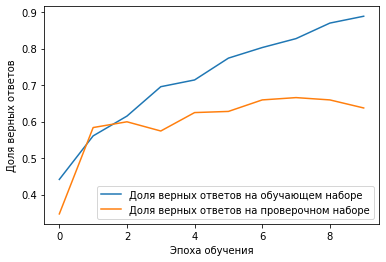

In [26]:
# Обучаем сеть на данных Cifar10
history = model.fit(x_train, 
                    y_train, 
                    batch_size=batch_size, 
                    epochs=10,
                    validation_data=(x_val, y_val),
                    verbose=1)

# Отображаем график точности обучения
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

Epoch 1/10
100/100 [==============================] - 3s 21ms/step - loss: 0.5153 - accuracy: 0.8497 - val_loss: 0.6967 - val_accuracy: 0.8388
Epoch 2/10
100/100 [==============================] - 2s 19ms/step - loss: 0.4326 - accuracy: 0.8753 - val_loss: 0.6752 - val_accuracy: 0.8325
Epoch 3/10
100/100 [==============================] - 2s 19ms/step - loss: 0.3245 - accuracy: 0.9019 - val_loss: 0.6741 - val_accuracy: 0.8338
Epoch 4/10
100/100 [==============================] - 2s 19ms/step - loss: 0.2517 - accuracy: 0.9209 - val_loss: 0.7563 - val_accuracy: 0.8200
Epoch 5/10
100/100 [==============================] - 2s 19ms/step - loss: 0.2190 - accuracy: 0.9328 - val_loss: 0.5929 - val_accuracy: 0.8462
Epoch 6/10
100/100 [==============================] - 2s 19ms/step - loss: 0.1507 - accuracy: 0.9519 - val_loss: 0.7756 - val_accuracy: 0.8263
Epoch 7/10
100/100 [==============================] - 2s 19ms/step - loss: 0.1664 - accuracy: 0.9484 - val_loss: 0.8711 - val_accuracy: 0.8075

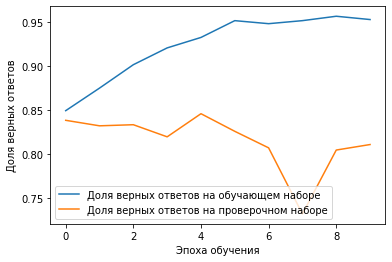

In [27]:
# Компилируем сеть и уменьшаем шаг обучения
model.compile(loss="categorical_crossentropy", optimizer=Adam(0.001), metrics=["accuracy"]) #Уменьшили шаг обучения

# Обучим нейросеть ещё на 10 эпохах. Дополнительно.

# Обучаем сеть на данных Cifar10
history = model.fit(x_train, 
                    y_train, 
                    batch_size=batch_size, 
                    epochs=10,
                    validation_split=0.2,
                    verbose=1)

# Отображаем график точности обучения
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [28]:
# Папка для хранения весов
fpath = "/content/drive/MyDrive/Colab Notebooks/Machine_learning/Images/6_Saving_weights_Additional_fitting/weights/flowers.hdf5"

# Сохранение весов в эту папку
import shutil

model.save_weights('flowers.hdf5') # Сохранение в оперативную память

shutil.copy('/content/flowers.hdf5', fpath) # Копирование в гугл диск.

# # Загрузка весов:

model.load_weights(fpath)